In [1]:
## Required installs
#pip install folium
#pip install geopandas
#pip install hvplot

In [45]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
from sklearn import preprocessing
import seaborn as sns
import hvplot.pandas
import missingno as msno

In [46]:
building_aesthetic=pd.read_csv('ApartmentBuildingEvaluation.csv')
neighborhood_data=gpd.read_file('Neighbourhoods.shp')

<AxesSubplot:>

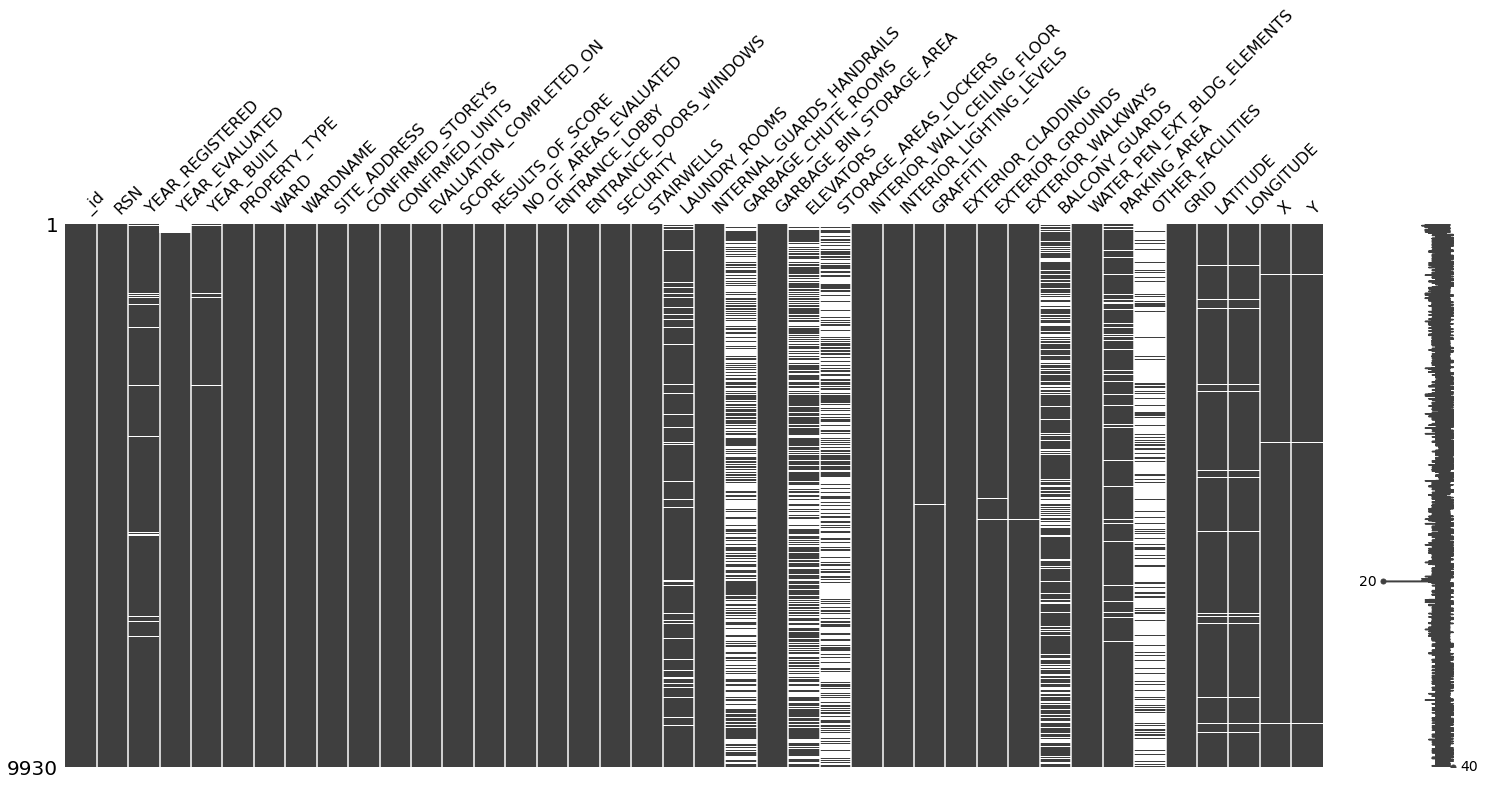

In [47]:
# EDA 
msno.matrix(building_aesthetic)

In [48]:
building_aesthetic['NO_OF_AREAS_EVALUATED'].mean(axis=0)

17.155287009063443

We see that alot of data is missing.Specifically the average number of areas evaulated is only 17/20.

In [49]:
(np.round((building_aesthetic.iloc[:,15:35].mean(axis=1)/5)*100))

0       53.0
1       80.0
2       85.0
3       93.0
4       65.0
        ... 
9925    76.0
9926    62.0
9927    70.0
9928    66.0
9929    68.0
Length: 9930, dtype: float64

In [50]:
building_aesthetic['SCORE']

0       53
1       80
2       85
3       93
4       65
        ..
9925    76
9926    62
9927    70
9928    66
9929    68
Name: SCORE, Length: 9930, dtype: int64

We see that rounding the mean values gives the score--- this means that nan values aren't being factored into the score.
To fix this we can set a limit for the number of components required to ensure that our measurements of the building aesthetics are confident. 

In [51]:
building_aesthetic=building_aesthetic[building_aesthetic.iloc[:,14]>15] # 15 is our threshold of components

Text(0.5, 1.0, 'Aesthetic Score Out of 100')

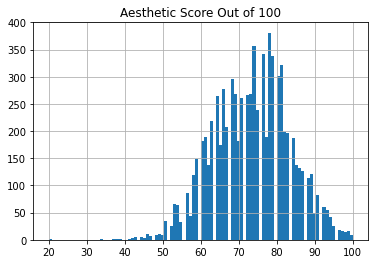

In [52]:
building_aesthetic['SCORE'].hist(bins=100)
plt.title('Aesthetic Score Out of 100')

In [53]:
print('Skew is: '+str(building_aesthetic['SCORE'].skew())[0:10])

Skew is: -0.1092641


<AxesSubplot:xlabel='LONGITUDE', ylabel='LATITUDE'>

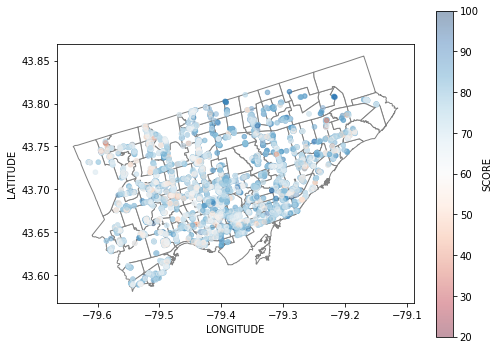

<Figure size 432x288 with 0 Axes>

In [54]:
#pd.options.plotting.backend = 'matplotlib'
fig, ax = plt.subplots(figsize=(8,6))
plt.figure()
neighborhood_data.plot(facecolor='white',
                         edgecolor='grey',
                         ax=ax) 

building_aesthetic.plot(x='LONGITUDE',
                      y='LATITUDE', 
                      kind='scatter',
                      c='SCORE', 
                      cmap='RdBu',
                      alpha=0.4,ax=ax)



In [55]:
# Here we convert a df into a gdf
building_aesthetic_gdf=gpd.GeoDataFrame(
    building_aesthetic,geometry=gpd.points_from_xy(building_aesthetic['LONGITUDE'],
                                                   building_aesthetic['LATITUDE']))

Group the Aesthtics of the Buildings in with the neighborhood data of the nighborhood crime dataset

In [56]:
# Load in the neighborhood crime data
neighborhood_crime_data=gpd.read_file('neighbourhood-crime-rates - 4326.geojson')

In [57]:
# Average Out the Aesthetic Scores of the Neighborhoods
Average_Aesthetic=[]
Average_Aesthetic_std=[]
Apartment_Counts=[]
for row,hood in enumerate(neighborhood_crime_data.iloc):
    # Calculate the Average Aesthetic per neighborhood
    Average_Aesthetic.append(np.mean(building_aesthetic_gdf[building_aesthetic_gdf['geometry'].within(hood['geometry'])]['SCORE']))
    Average_Aesthetic_std.append(np.std(building_aesthetic_gdf[building_aesthetic_gdf['geometry'].within(hood['geometry'])]['SCORE']))
    Apartment_Counts.append(building_aesthetic_gdf['geometry'].within(hood['geometry']).sum())

In [58]:
neighborhood_crime_data['Average Aesthetic']=Average_Aesthetic
neighborhood_crime_data['Average Aesthetic std']=Average_Aesthetic_std
neighborhood_crime_data['Num of Apartment (RentSafeTO)']=Apartment_Counts

In [99]:
#pd.options.plotting.backend = 'holoviews'
#fig,ax=plt.subplots(figsize=(12,8))

neighborhood_crime_data.hvplot(
    c='Average Aesthetic',
    hover_cols=['HoodName'],
    cmap='Blues',
    title='Average Aesthetic Score (-/100) of Apartments (2021)'
)

:Polygons   [x,y]   (Average Aesthetic,HoodName)

In [60]:
# Higher Standard Deviation shows that the buildings vary significantly within
# the neighborhood
neighborhood_crime_data.hvplot(
    c='Average Aesthetic std',
    hover_cols=['HoodName'],
    cmap='inferno',
    title='Standard Deviation of Apartment Aesthetic Score'
)

:Polygons   [x,y]   (Average Aesthetic std,HoodName)

In [61]:
# This Predcits how easy it would be able to find an apartment
neighborhood_crime_data.hvplot(
    c='Num of Apartment (RentSafeTO)',
    hover_cols=['HoodName'],
    cmap='Greys',
    title='Number of Apartments (RentSafeTO)'
)

:Polygons   [x,y]   (Num of Apartment (RentSafeTO),HoodName)

#Crime Analysis
Let's take a look at the neighborhood trends for each neighborhood to predict it's improvement in thefts

In [62]:
crime_columns=neighborhood_crime_data[['TheftOver_Rate2021',
                                           'Assault_Rate2021',
                                           'BreakAndEnter_Rate2021',
                                           'Robbery_Rate2021',
                                           'TheftfromMotorVehicle_Rate2021',
                                           'Average Aesthetic',
                                           'F2021_Population_Projection',
                                           'Num of Apartment (RentSafeTO)']]

In [63]:
crime_columns.corr()

TheftOver_Rate2021  Assault_Rate2021  \
TheftOver_Rate2021                        1.000000          0.482038   
Assault_Rate2021                          0.482038          1.000000   
BreakAndEnter_Rate2021                    0.552507          0.685232   
Robbery_Rate2021                          0.462077          0.770923   
TheftfromMotorVehicle_Rate2021            0.625323          0.367203   
Average Aesthetic                        -0.078001         -0.304407   
F2021_Population_Projection               0.135759          0.151098   
Num of Apartment (RentSafeTO)             0.020236          0.174893   

                                BreakAndEnter_Rate2021  Robbery_Rate2021  \
TheftOver_Rate2021                            0.552507          0.462077   
Assault_Rate2021                              0.685232          0.770923   
BreakAndEnter_Rate2021                        1.000000          0.628461   
Robbery_Rate2021                              0.628461          1.000000   
TheftfromMotorVehicle_Rate2021                0.410704          0.384722   
Average Aesthetic                            -0.119062         -0.136558   
F2021_Population_Projection                   0.076213          0.128728   
Num of Apartment (RentSafeTO)                 0.060641          0.078447   

                                TheftfromMotorVehicle_Rate2021  \
TheftOver_Rate2021                                    0.625323   
Assault_Rate2021                                      0.367203   
BreakAndEnter_Rate2021                                0.410704   
Robbery_Rate2021                                      0.384722   
TheftfromMotorVehicle_Rate2021                        1.000000   
Average Aesthetic                                    -0.119235   
F2021_Population_Projection                           0.029211   
Num of Apartment (RentSafeTO)                         0.023507   

                                Average Aesthetic  \
TheftOver_Rate2021                      -0.078001   
Assault_Rate2021                        -0.304407   
BreakAndEnter_Rate2021                  -0.119062   
Robbery_Rate2021                        -0.136558   
TheftfromMotorVehicle_Rate2021          -0.119235   
Average Aesthetic                        1.000000   
F2021_Population_Projection              0.214638   
Num of Apartment (RentSafeTO)           -0.137143   

                                F2021_Population_Projection  \
TheftOver_Rate2021                                 0.135759   
Assault_Rate2021                                   0.151098   
BreakAndEnter_Rate2021                             0.076213   
Robbery_Rate2021                                   0.128728   
TheftfromMotorVehicle_Rate2021                     0.029211   
Average Aesthetic                                  0.214638   
F2021_Population_Projection                        1.000000   
Num of Apartment (RentSafeTO)                      0.291756   

                                Num of Apartment (RentSafeTO)  
TheftOver_Rate2021                                   0.020236  
Assault_Rate2021                                     0.174893  
BreakAndEnter_Rate2021                               0.060641  
Robbery_Rate2021                                     0.078447  
TheftfromMotorVehicle_Rate2021                       0.023507  
Average Aesthetic                                   -0.137143  
F2021_Population_Projection                          0.291756  
Num of Apartment (RentSafeTO)                        1.000000

Text(0.5, 1.0, 'Number of Apartments as of 2021 and Neighborhood Population Correlating to Crime Rates')

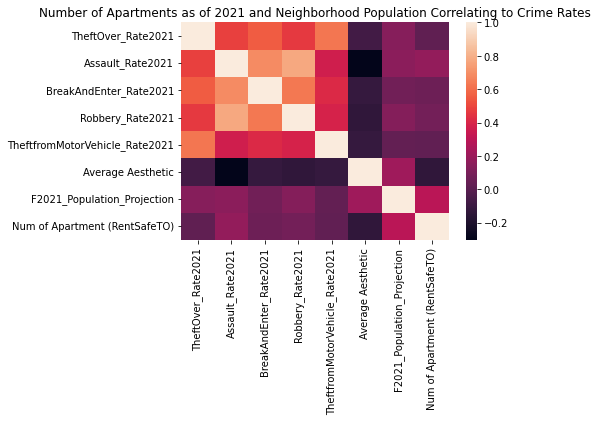

In [96]:
sns.heatmap(crime_columns.corr())
plt.title('Number of Apartments as of 2021 and Neighborhood Population Correlating to Crime Rates')

From this heatmap we can see a few interesting trends. For one, we see a slight negative correlation between the number of apartments and the average aesthetic of the buildings. We also see that the assault rate is somewhat correlated with the number of people in a neighborhood and the number of apartments in the neihborhood. As expected we see a negative correlation between the aesthetics of the neighborhood and the various crime rates.

In [65]:
neighborhood_crime_data.hvplot(
    c='Assault_Rate2021',
    hover_cols=['HoodName'],
    cmap='Reds',
    legend=True,
    title='Assault Rate 2021'
)

:Polygons   [x,y]   (Assault_Rate2021,HoodName)

In [66]:
neighborhood_crime_data.sort_values('Assault_Rate2021',ascending=False)[['HoodName','Assault_Rate2021']].iloc[0:3]

HoodName  Assault_Rate2021
130              Moss Park          2569.646
22   Church-Yonge Corridor          2367.415
51    Kensington-Chinatown          1854.226

In [67]:
neighborhood_crime_data.sort_values('Assault_Rate2021',ascending=True)[['HoodName','Assault_Rate2021']].iloc[0:3]

HoodName  Assault_Rate2021
54      Forest Hill South          125.6281
135         Pleasant View          152.4658
114  Bedford Park-Nortown          153.8692

The Latest Dataset shows that Moss Park, Church-Yong Corridor and Kensington-Chinatown have the highest rates of Assault while Forest Hill osuth, Pleasant View and Bedfor Park-Nortown have the lowest rates of assault

In [68]:
Assault_Trends=neighborhood_crime_data[['HoodName',
                                 'Assault_Rate2014',
                                 'Assault_Rate2015',
                                 'Assault_Rate2016',
                                 'Assault_Rate2017',
                                 'Assault_Rate2018',
                                 'Assault_Rate2019',
                                 'Assault_Rate2020',
                                 'Assault_Rate2021']]

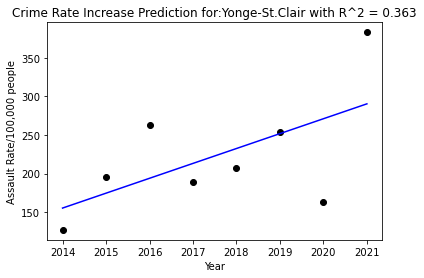

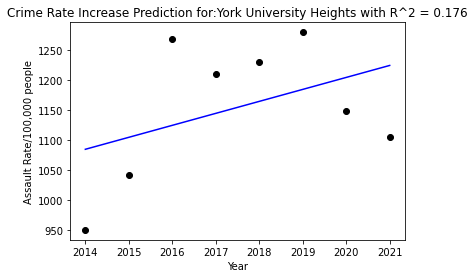

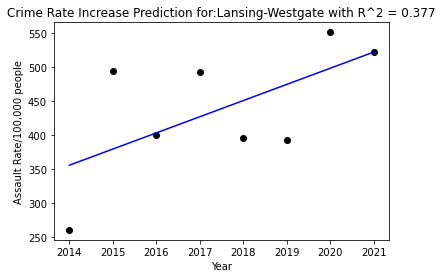

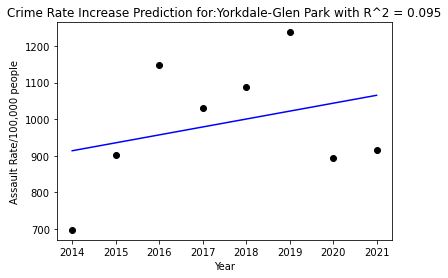

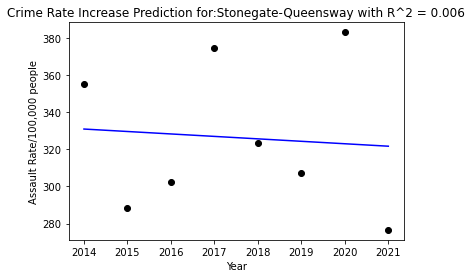

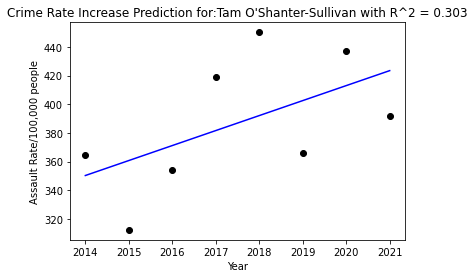

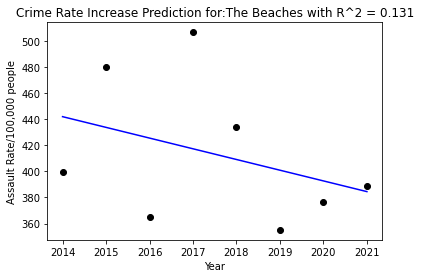

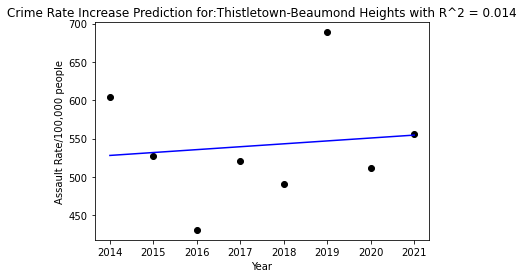

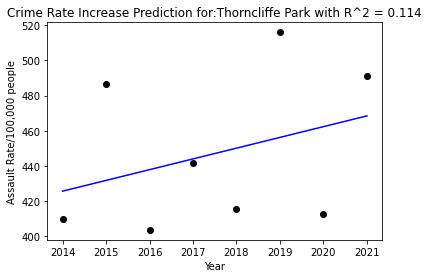

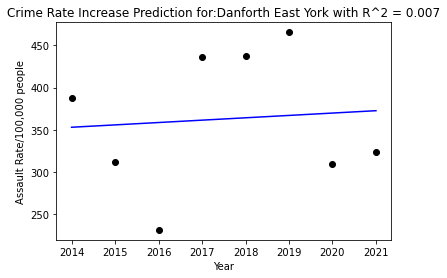

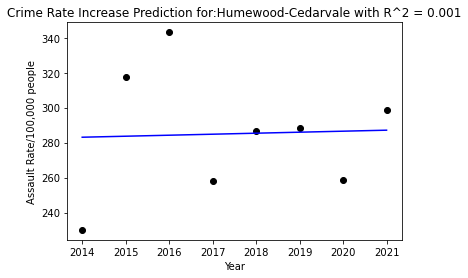

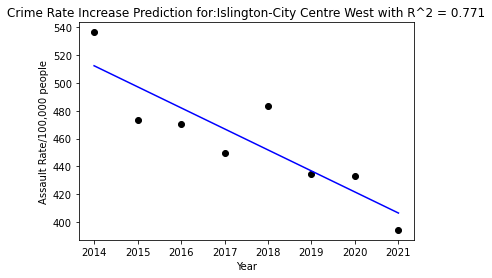

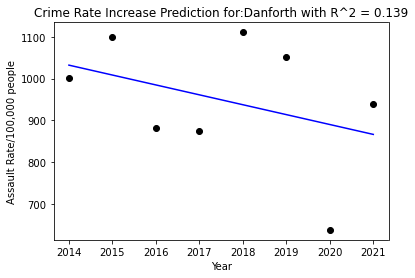

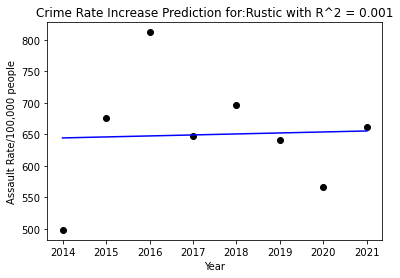

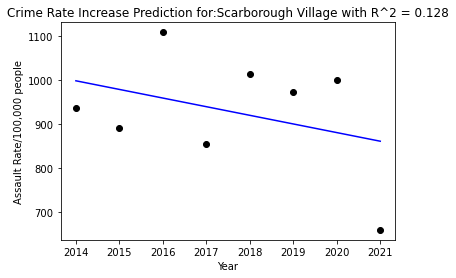

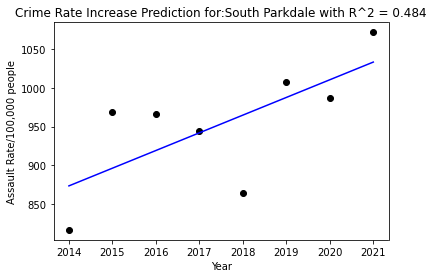

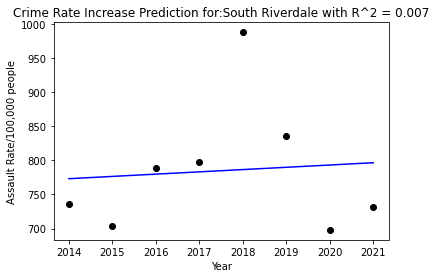

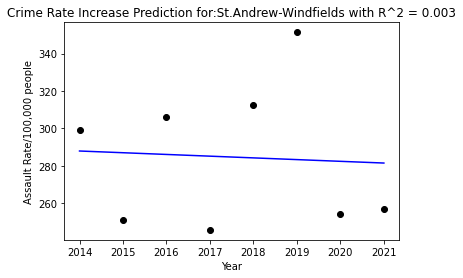

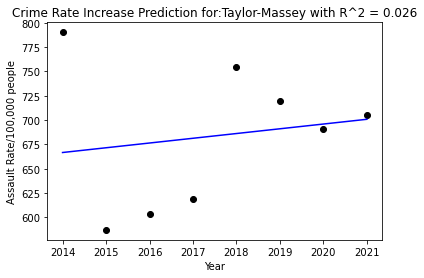

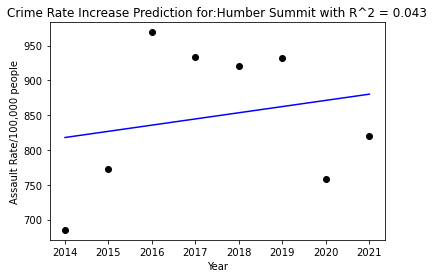

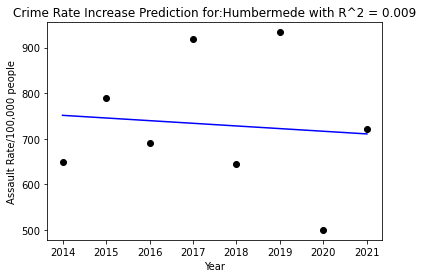

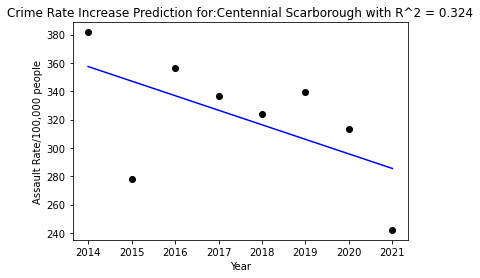

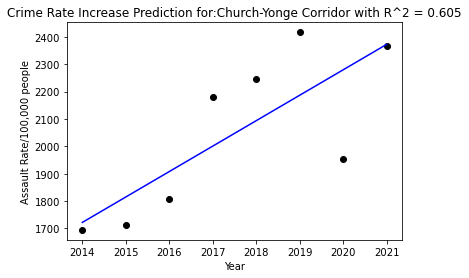

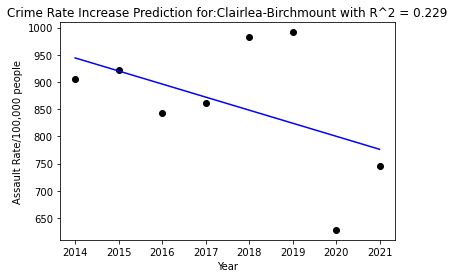

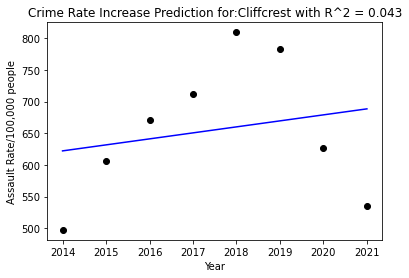

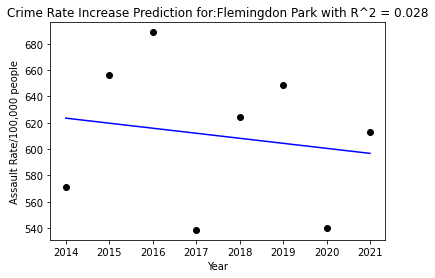

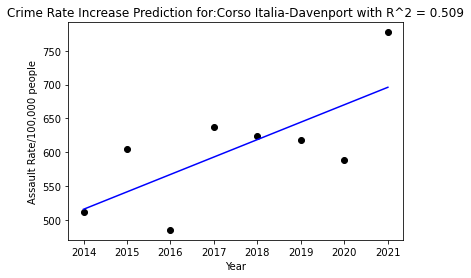

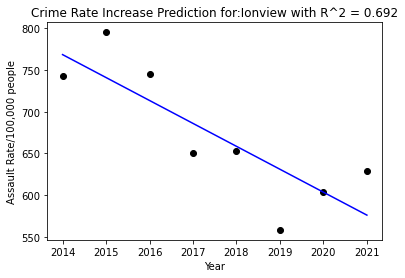

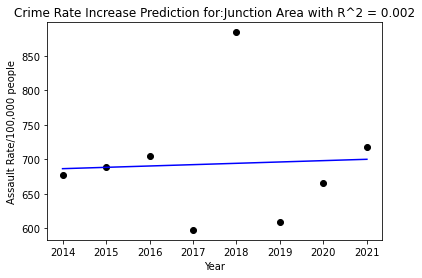

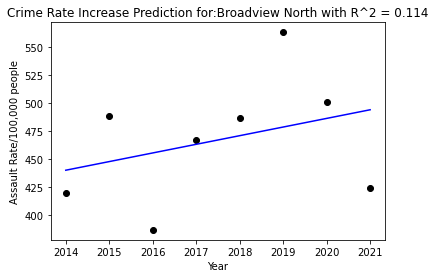

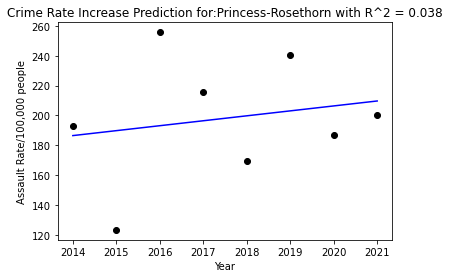

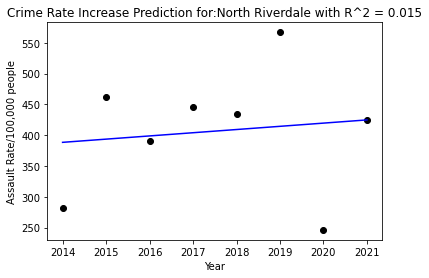

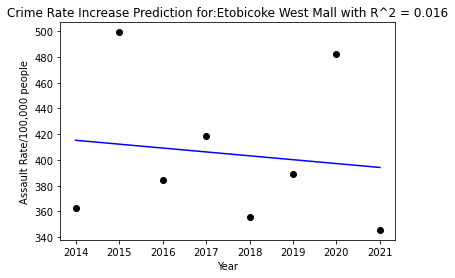

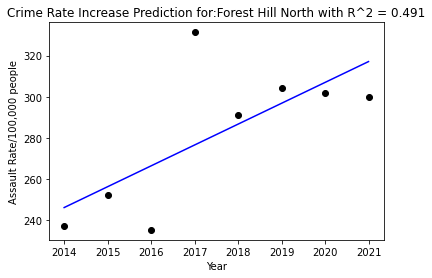

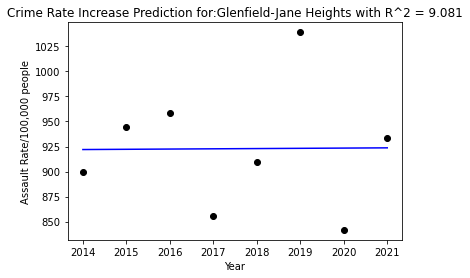

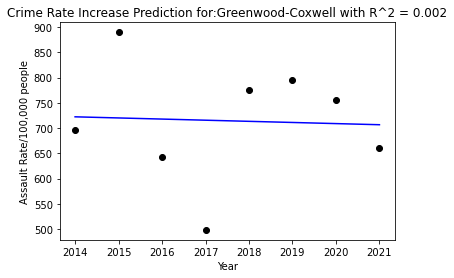

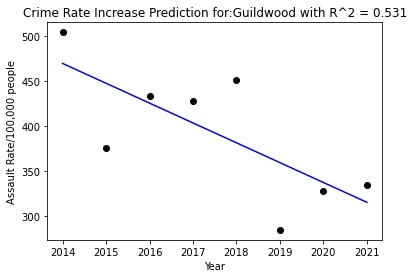

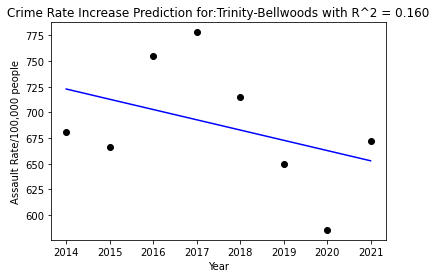

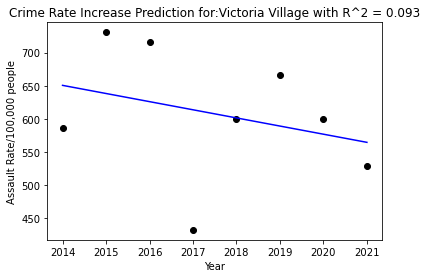

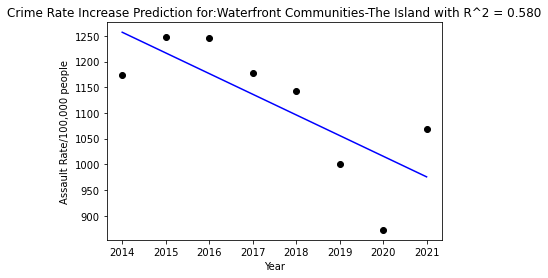

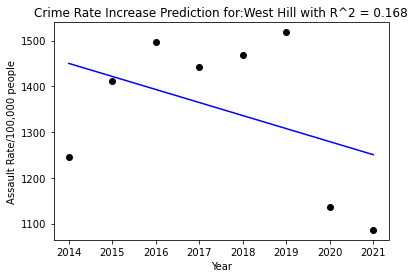

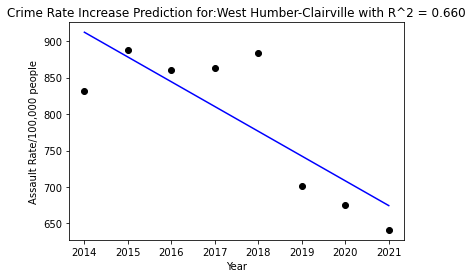

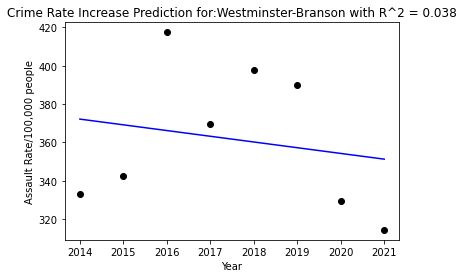

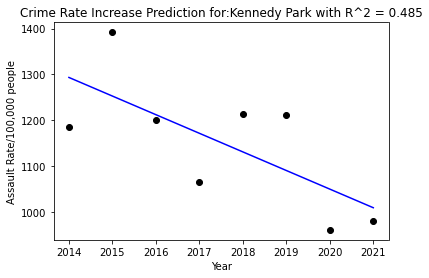

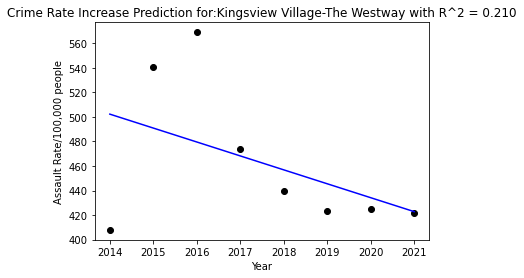

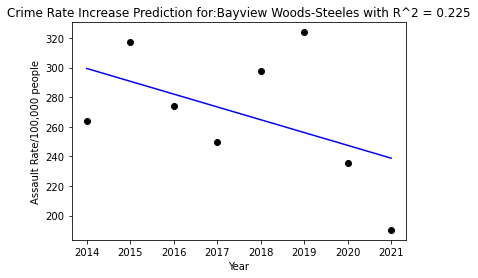

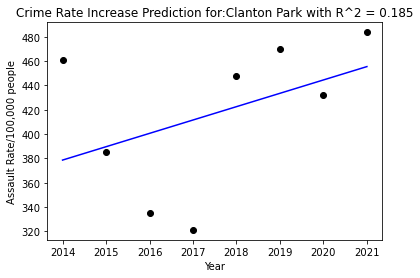

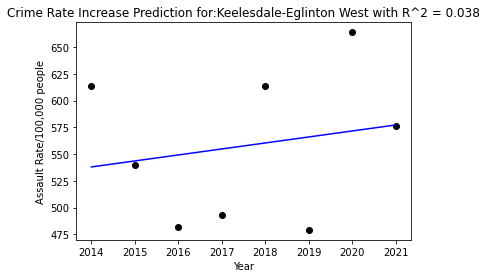

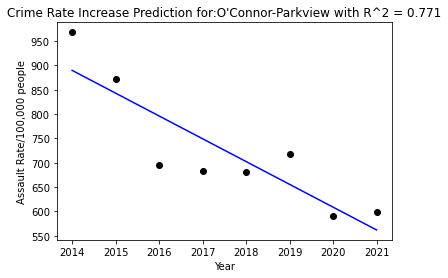

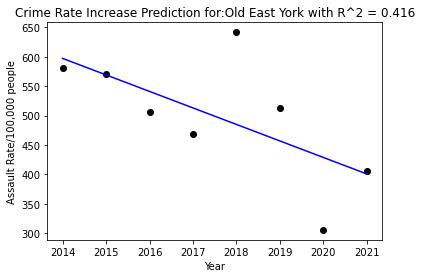

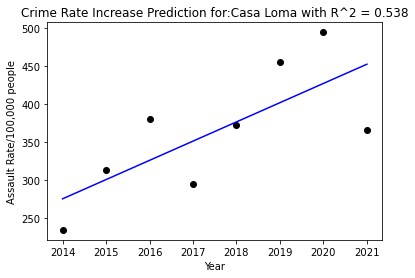

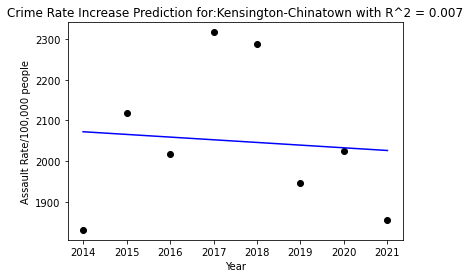

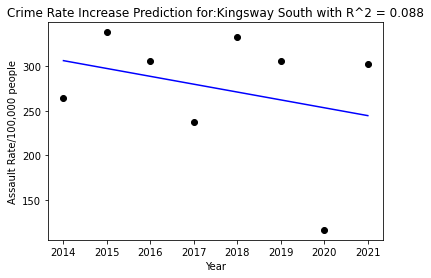

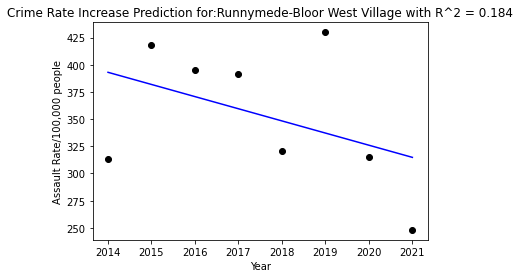

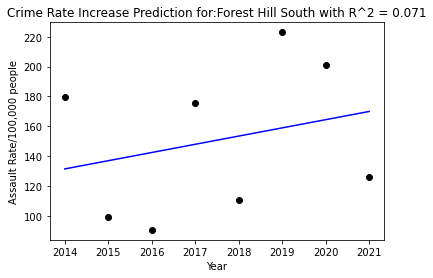

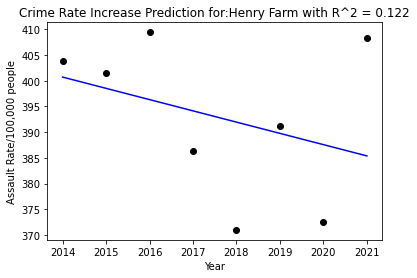

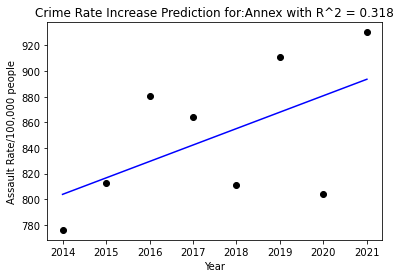

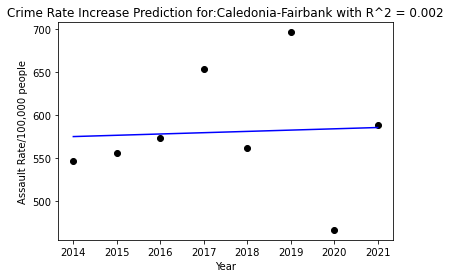

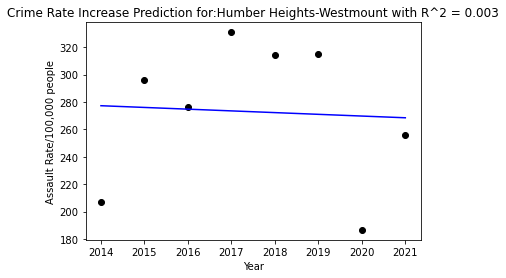

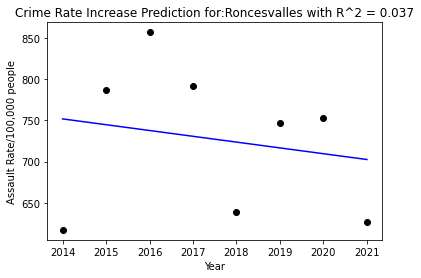

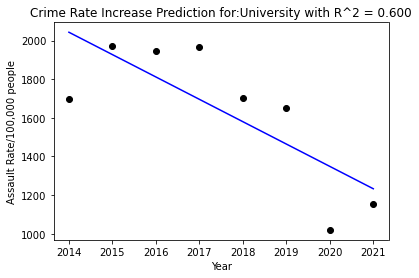

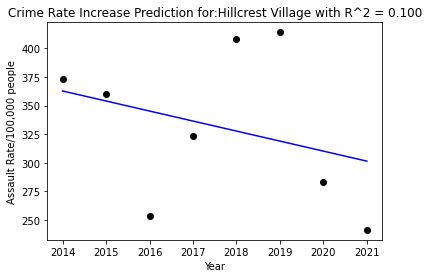

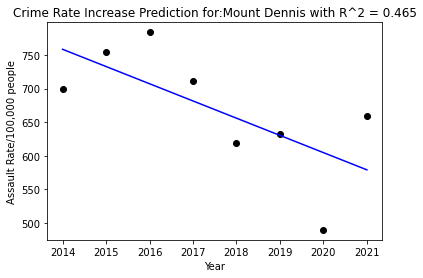

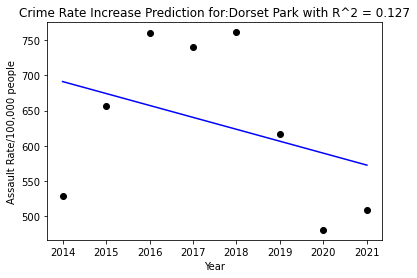

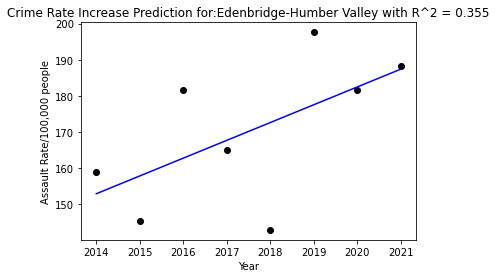

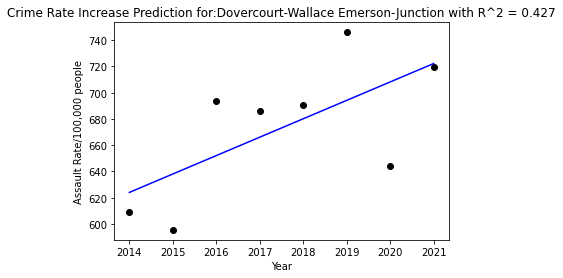

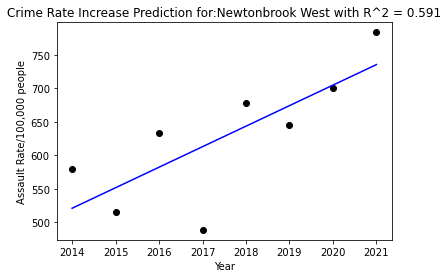

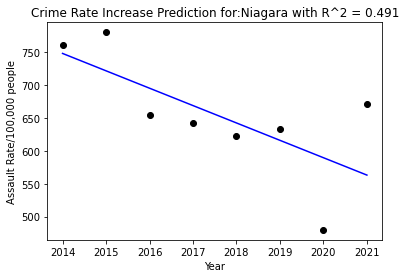

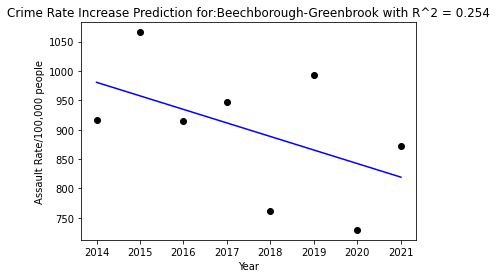

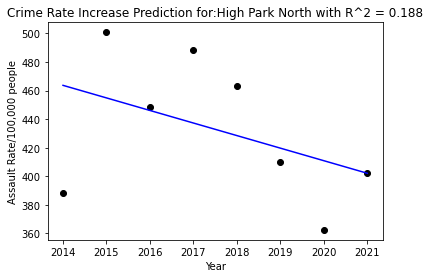

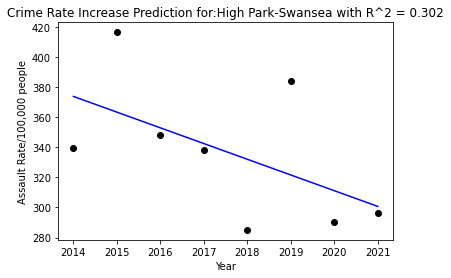

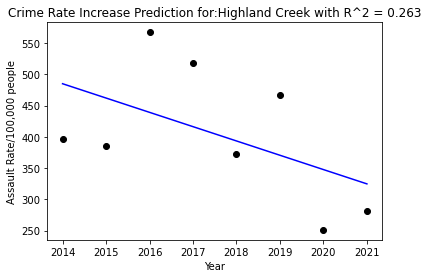

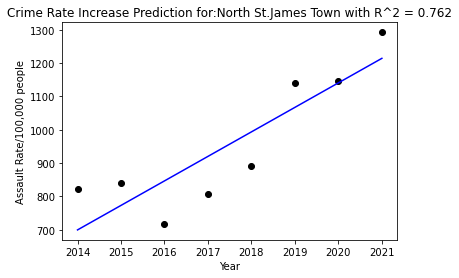

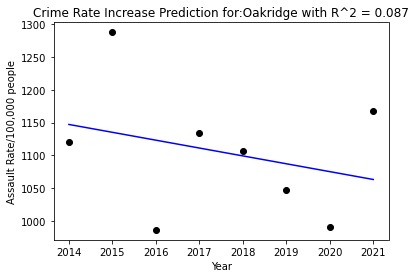

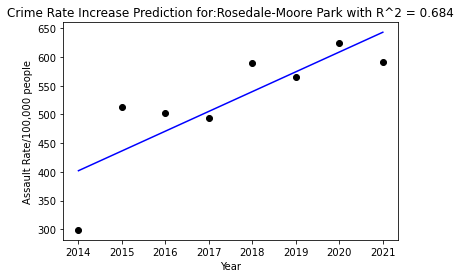

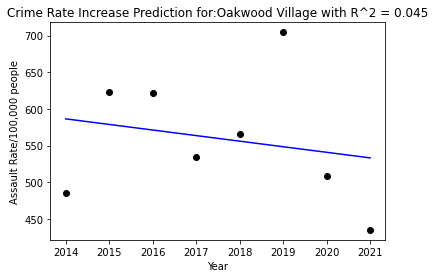

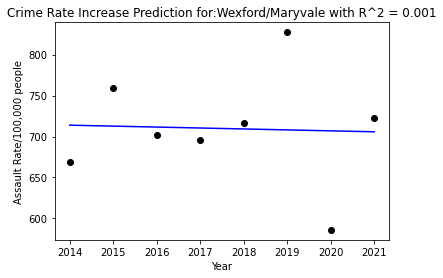

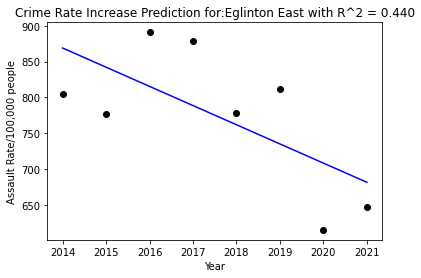

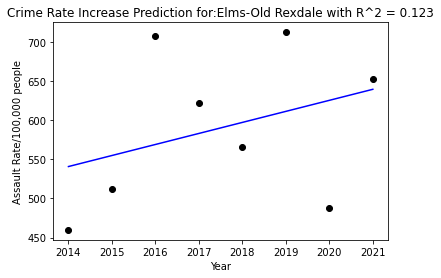

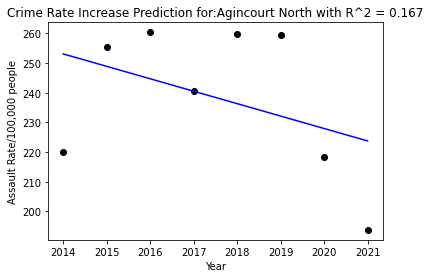

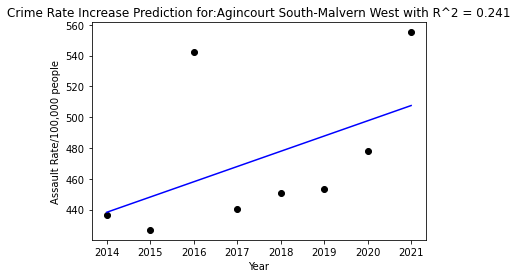

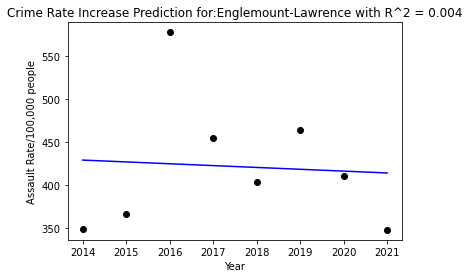

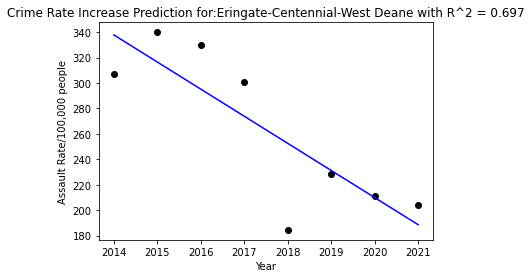

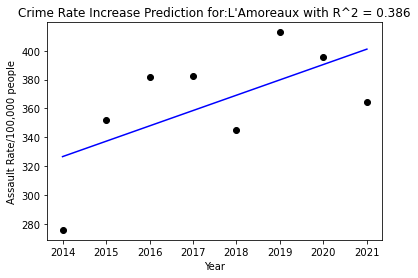

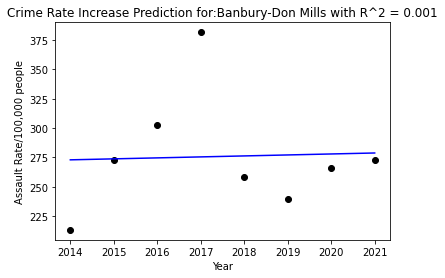

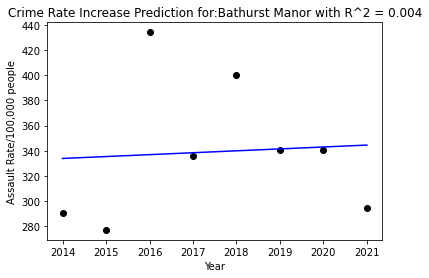

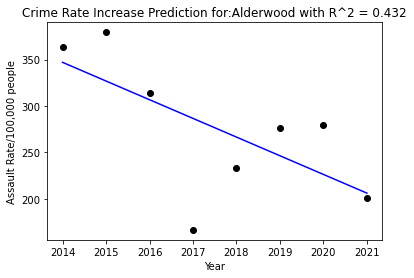

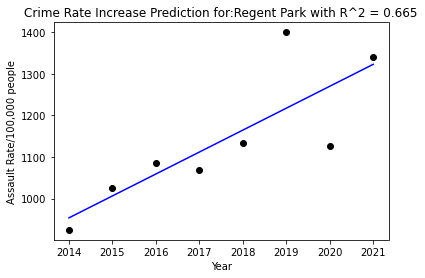

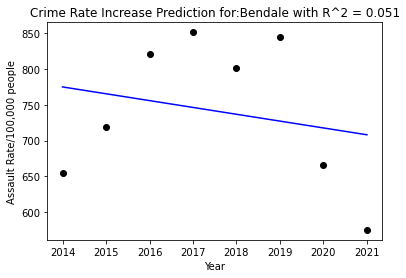

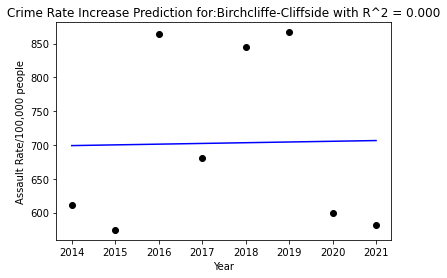

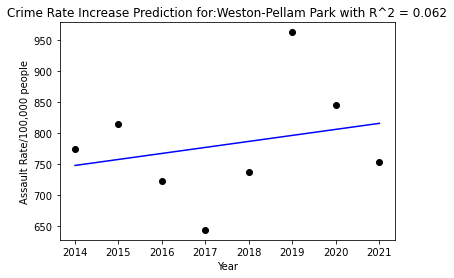

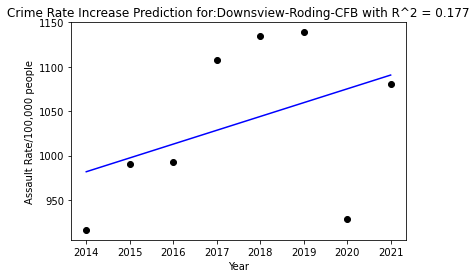

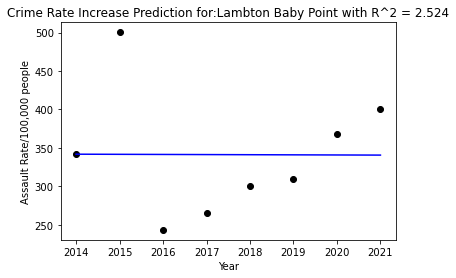

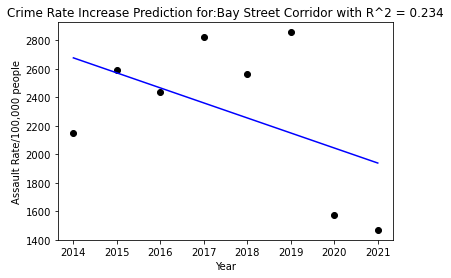

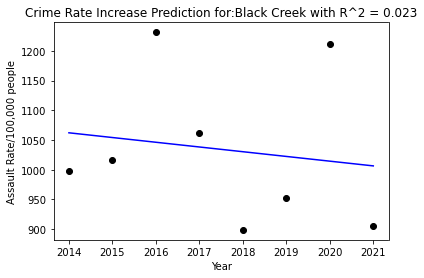

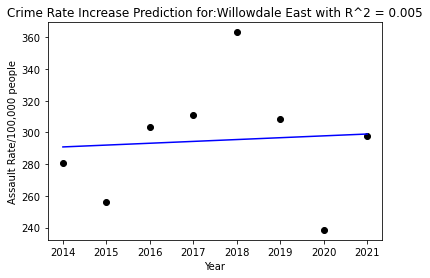

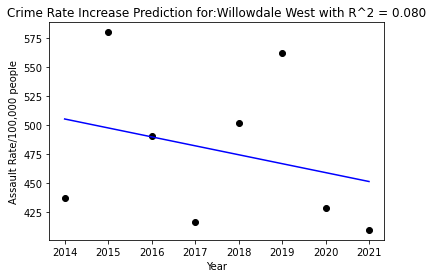

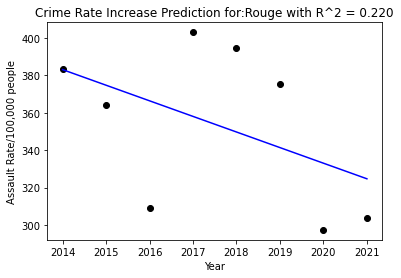

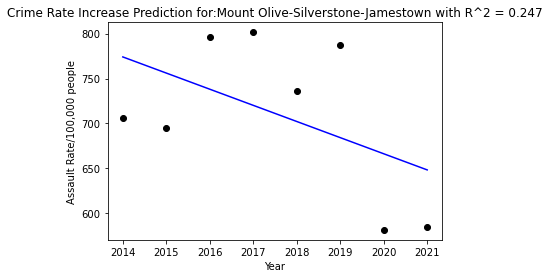

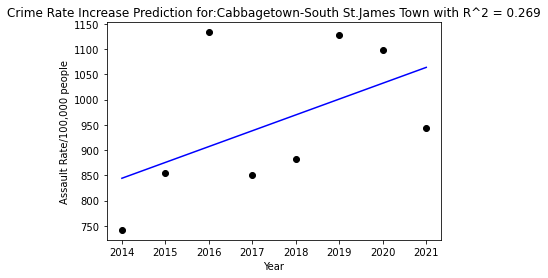

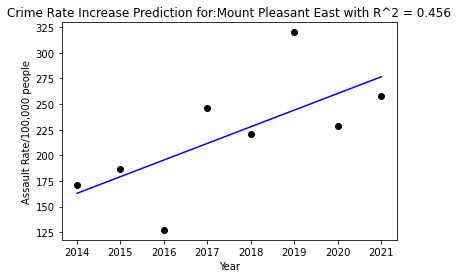

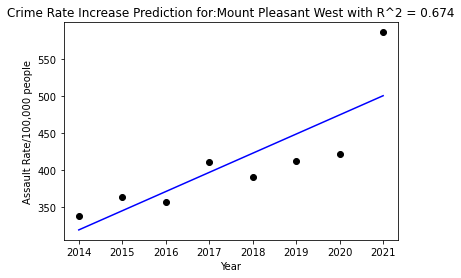

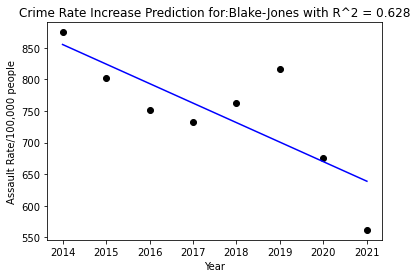

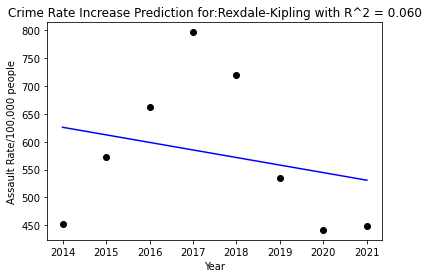

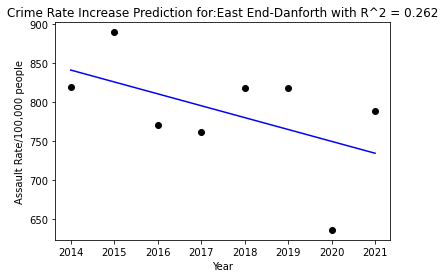

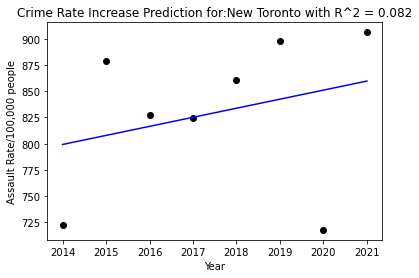

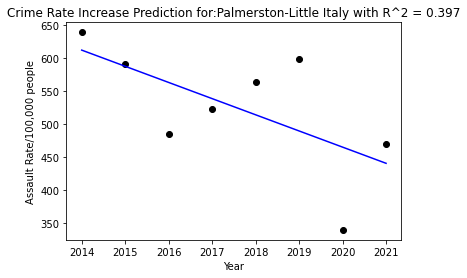

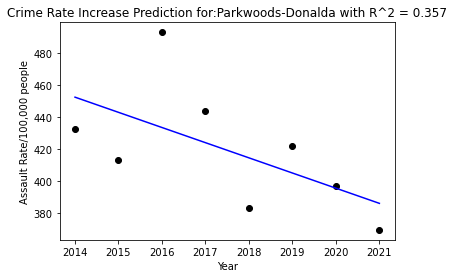

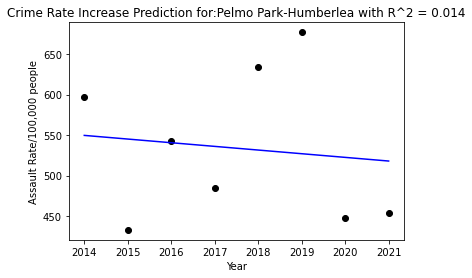

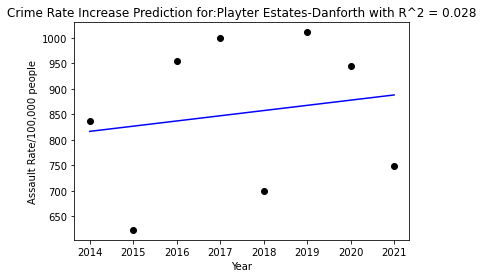

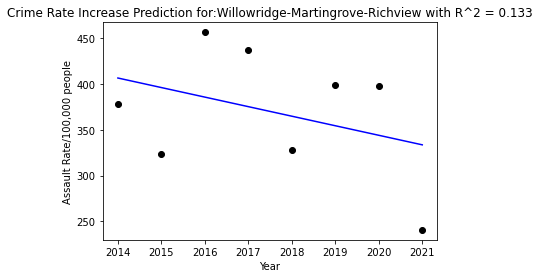

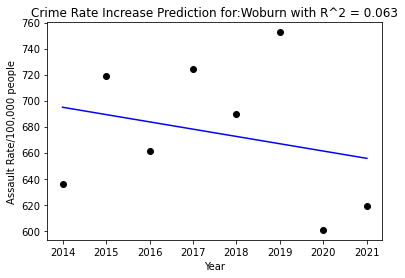

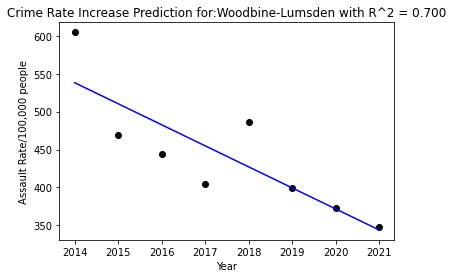

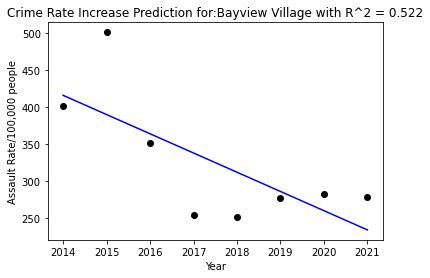

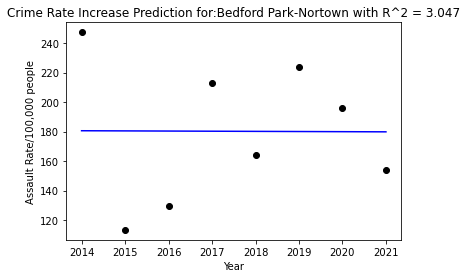

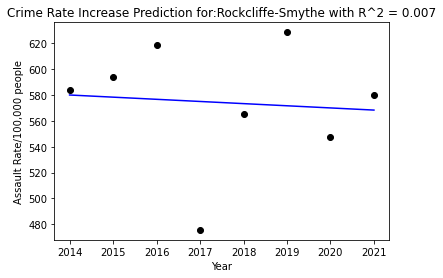

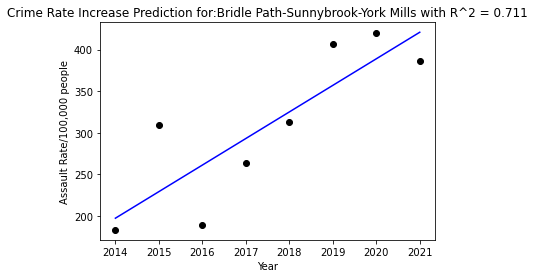

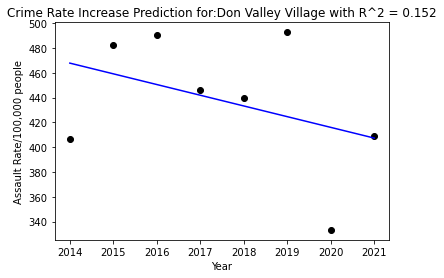

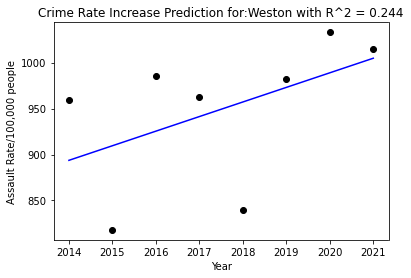

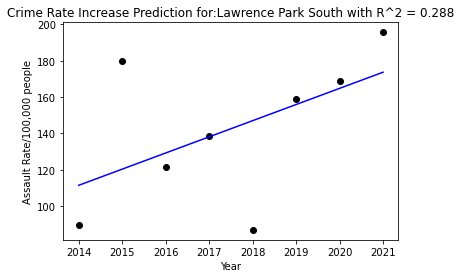

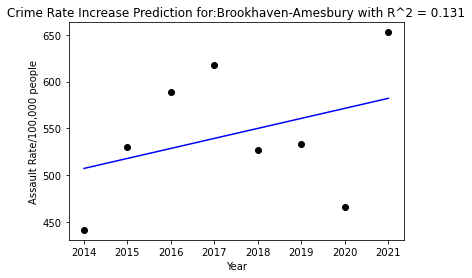

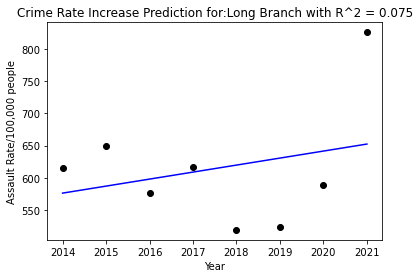

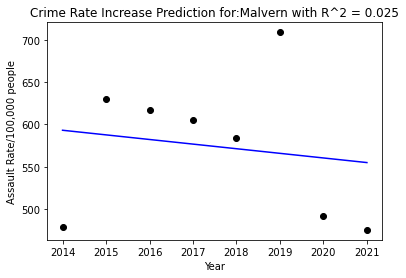

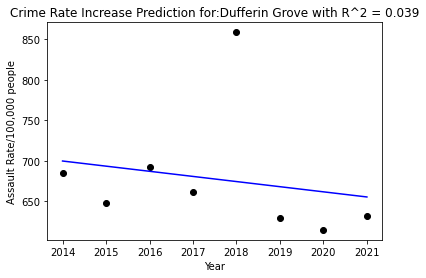

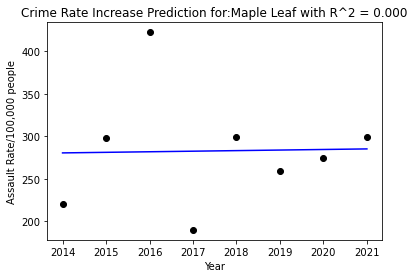

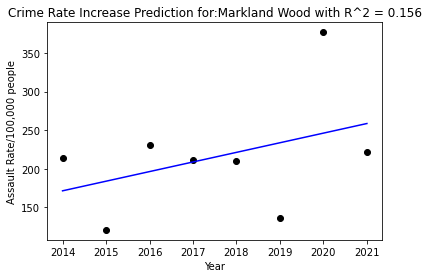

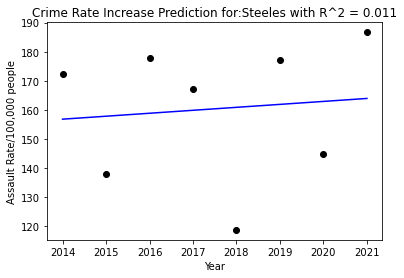

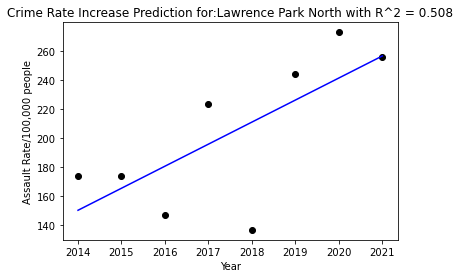

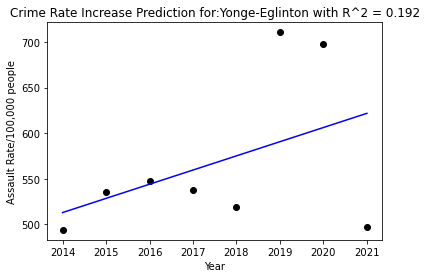

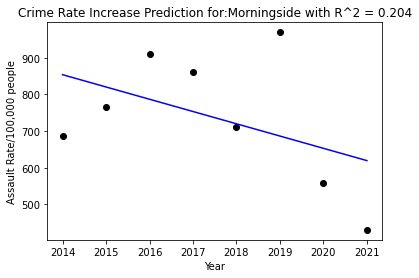

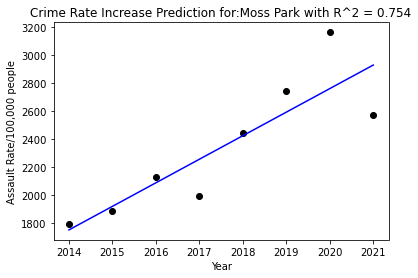

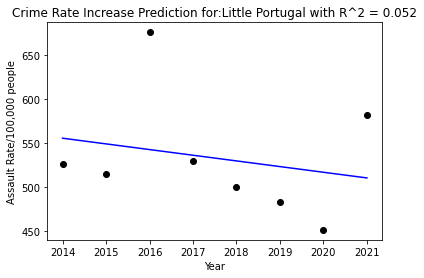

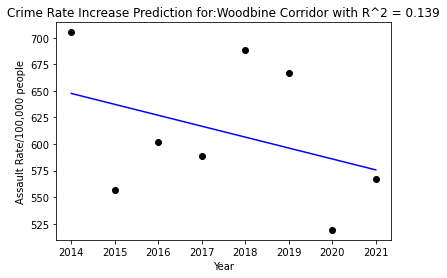

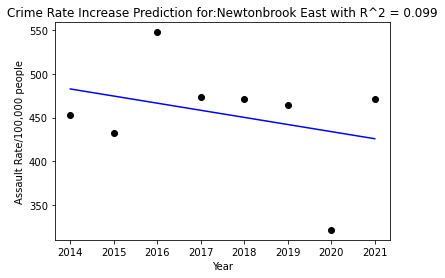

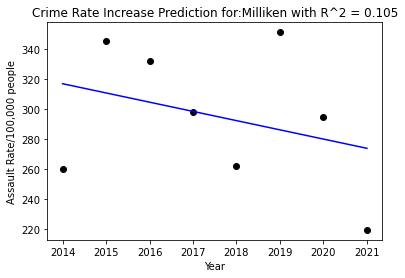

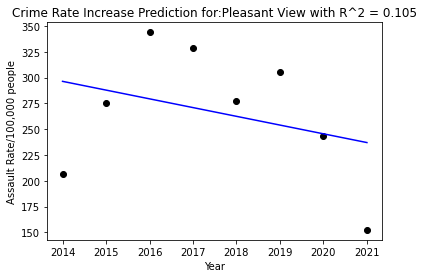

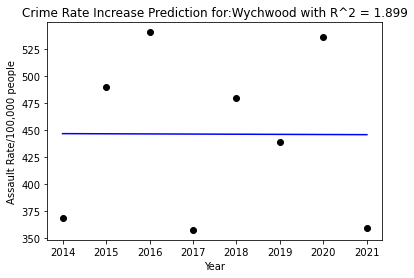

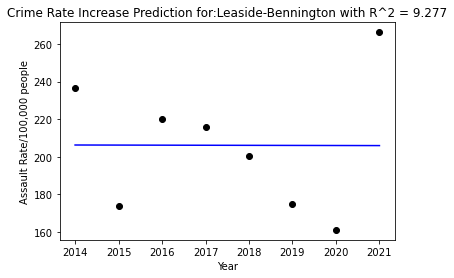

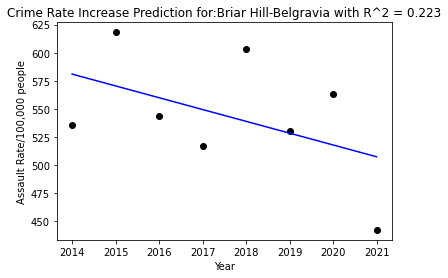

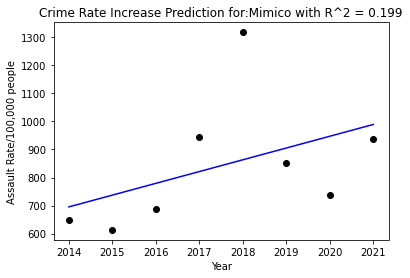

In [100]:
# Perform Predictions on Assault Rate
from sklearn.linear_model import LinearRegression
years=[[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021]]
model=LinearRegression()
R_2_scores=[]
model_intercepts=[]
model_coeff=[]

for hood in Assault_Trends.iloc:
  hoodname=hood['HoodName']
  y_data=hood[1:].values
  model.fit(years,y_data)
  R_2_scores.append(model.score(years,y_data))
  model_coeff.append(model.coef_[0])
  model_intercepts.append(model.intercept_)
  y_pred=model.predict(years)
  plt.scatter(years,y_data,color='black')
  plt.plot(years,y_pred,color='blue')
  plt.title('Crime Rate Increase Prediction for:'+ hoodname+' with R^2 = '+ str(model.score(years,y_data))[0:5])
  plt.ylabel('Assault Rate/100,000 people')
  plt.xlabel('Year')
  plt.show()

In [70]:
neighborhood_crime_data['Assualts, Linear Fit Slope']=model_coeff
neighborhood_crime_data['Assualts, Linear Fit Intercept']=model_intercepts
neighborhood_crime_data['Assualts, Linear Fit Score']=R_2_scores

In [77]:
#plot The expected Crime Rate Using a scorer greater thgan 0.2
neighborhood_crime_high_scores=neighborhood_crime_data[neighborhood_crime_data['Assualts, Linear Fit Score']>0.2]
neighborhood_crime_high_scores.hvplot(
    c='Assualts, Linear Fit Slope',
    hover_cols=['HoodName','Assualts, Linear Fit Score'],
    cmap='seismic',
    legend=True,
    title='Rising Rates of Assault /100,000 People')
#title('Rising or Declining Rates of Assault /100,000 People')

:Polygons   [x,y]   (Assualts, Linear Fit Slope,HoodName,Assualts, Linear Fit Score)

In [78]:
neighborhood_crime_high_scores.sort_values('Assualts, Linear Fit Slope',ascending=False)[['HoodName','Assualts, Linear Fit Slope','Assualts, Linear Fit Score']].iloc[0:3]

HoodName  Assualts, Linear Fit Slope  \
130              Moss Park                  167.811738   
22   Church-Yonge Corridor                   92.890476   
72     North St.James Town                   73.508545   

     Assualts, Linear Fit Score  
130                    0.754164  
22                     0.605795  
72                     0.762592

In [79]:
neighborhood_crime_high_scores.sort_values('Assualts, Linear Fit Slope',ascending=True)[['HoodName','Assualts, Linear Fit Slope','Assualts, Linear Fit Score']].iloc[0:3]

HoodName  Assualts, Linear Fit Slope  \
60           University                 -115.718583   
93  Bay Street Corridor                 -105.437595   
48    O'Connor-Parkview                  -46.840818   

    Assualts, Linear Fit Score  
60                    0.600159  
93                    0.234307  
48                    0.771069

The Places with a rapidly lowering crime rates (Assaults) are University, Bay Street Corridor, O'Connor-Parkview and Kennedy Park.
The Neighborhoods with the most rapidily rising crime rates (Assaults) are Moss Park, Church-Yong Corridor and North St. James Town

# Home Prices

Note that the latest available home prices are from 2011 which are unfortunately very much outdated so some caution must be taken.

In [80]:
home_prices=pd.read_excel('wellbeing-toronto-housing.xlsx','RawDataRef_2011')

In [81]:

neighboorhood_2011_price=[]
for neighborhood_crime_instance in neighborhood_crime_data.iloc:
  try:
    neighboorhood_2011_price.append((home_prices[home_prices['Neighbourhood']==neighborhood_crime_instance['HoodName']]['Home Prices']).values[0])
    # Some Neighborhoods exist in the neighborhood crime set but not in the home prices
  except: 
    neighboorhood_2011_price.append(np.nan)

Text(0.5, 1.0, 'Histogram of 2011 Home Prices')

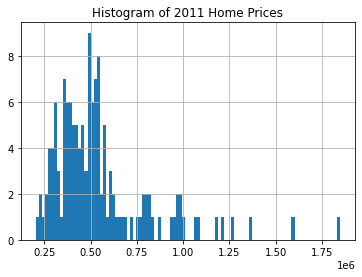

In [82]:

neighborhood_crime_data['Home Prices']=neighboorhood_2011_price
neighborhood_crime_data['Home Prices'].hist(bins=100)
plt.title('Histogram of 2011 Home Prices')

In [83]:
neighborhood_crime_data['Home Prices'].skew()

1.9773291975112226

In [84]:
print('Average Home Price in Toronto (2011): ' +str(neighborhood_crime_data['Home Prices'].mean()))
print('Median Home Price in Toronto (2011): ' +str(neighborhood_crime_data['Home Prices'].median()))

Average Home Price in Toronto (2011): 548664.6376811594
Median Home Price in Toronto (2011): 490972.0


In [85]:
neighborhood_crime_data.sort_values('Home Prices',ascending=False)[['HoodName','Home Prices']].iloc[0:3]

HoodName  Home Prices
116  Bridle Path-Sunnybrook-York Mills    1849084.0
54                   Forest Hill South    1585984.0
17                St.Andrew-Windfields    1363202.0

In [86]:
neighborhood_crime_data.sort_values('Home Prices',ascending=True)[['HoodName','Home Prices']].iloc[0:3]

HoodName  Home Prices
25   Flemingdon Park     204104.0
78  Elms-Old Rexdale     233832.0
94       Black Creek     235143.0

In [87]:
neighborhood_crime_data.hvplot(
    c='Home Prices',
    hover_cols=['HoodName'],
    cmap='Blues_r',
    title='Price of Homes (2011)'
)
#plt.title('Home Prices 2011')

:Polygons   [x,y]   (Home Prices,HoodName)

In [88]:
neighborhood_crime_data['Home Prices']=neighboorhood_2011_price
neighborhood_crime_data.hvplot(
    c='Home Prices',
    hover_cols=['HoodName'],
    cmap='Reds',
    legend=True,
    title='Price of Homes (2011)'
)
#plt.title('Home Prices 2011')

:Polygons   [x,y]   (Home Prices,HoodName)

Correlating Crime Rate to Housing Prices

In [89]:
# We want to correlate 2011 Housing Prices to Crime Rates so we will look at 
# 2014 Crime Rates
neighborhood_crime_2014=neighborhood_crime_data[['Assault_Rate2014',
                                            'AutoTheft_Rate2014',
                                            'BreakAndEnter_Rate2014',
                                            'Robbery_Rate2014',
                                            'TheftOver_Rate2014',
                                            'Homicide_Rate2014',
                                            'Shooting_Rate2014',
                                            'TheftfromMotorVehicle_Rate2014',
                                            'Home Prices']]

In [90]:
neighborhood_crime_2014.corr()

Assault_Rate2014  AutoTheft_Rate2014  \
Assault_Rate2014                        1.000000            0.142481   
AutoTheft_Rate2014                      0.142481            1.000000   
BreakAndEnter_Rate2014                  0.466618            0.150250   
Robbery_Rate2014                        0.801809            0.198850   
TheftOver_Rate2014                      0.482530            0.364447   
Homicide_Rate2014                      -0.119628           -0.180073   
Shooting_Rate2014                       0.251362            0.068576   
TheftfromMotorVehicle_Rate2014          0.510289            0.248661   
Home Prices                            -0.363835           -0.213506   

                                BreakAndEnter_Rate2014  Robbery_Rate2014  \
Assault_Rate2014                              0.466618          0.801809   
AutoTheft_Rate2014                            0.150250          0.198850   
BreakAndEnter_Rate2014                        1.000000          0.508014   
Robbery_Rate2014                              0.508014          1.000000   
TheftOver_Rate2014                            0.446466          0.350109   
Homicide_Rate2014                             0.246833         -0.212847   
Shooting_Rate2014                            -0.097103          0.246227   
TheftfromMotorVehicle_Rate2014                0.541180          0.460046   
Home Prices                                   0.300702         -0.285253   

                                TheftOver_Rate2014  Homicide_Rate2014  \
Assault_Rate2014                          0.482530          -0.119628   
AutoTheft_Rate2014                        0.364447          -0.180073   
BreakAndEnter_Rate2014                    0.446466           0.246833   
Robbery_Rate2014                          0.350109          -0.212847   
TheftOver_Rate2014                        1.000000          -0.208544   
Homicide_Rate2014                        -0.208544           1.000000   
Shooting_Rate2014                         0.022248          -0.040478   
TheftfromMotorVehicle_Rate2014            0.479068           0.003220   
Home Prices                               0.085530           0.055909   

                                Shooting_Rate2014  \
Assault_Rate2014                         0.251362   
AutoTheft_Rate2014                       0.068576   
BreakAndEnter_Rate2014                  -0.097103   
Robbery_Rate2014                         0.246227   
TheftOver_Rate2014                       0.022248   
Homicide_Rate2014                       -0.040478   
Shooting_Rate2014                        1.000000   
TheftfromMotorVehicle_Rate2014           0.013256   
Home Prices                             -0.201982   

                                TheftfromMotorVehicle_Rate2014  Home Prices  
Assault_Rate2014                                      0.510289    -0.363835  
AutoTheft_Rate2014                                    0.248661    -0.213506  
BreakAndEnter_Rate2014                                0.541180     0.300702  
Robbery_Rate2014                                      0.460046    -0.285253  
TheftOver_Rate2014                                    0.479068     0.085530  
Homicide_Rate2014                                     0.003220     0.055909  
Shooting_Rate2014                                     0.013256    -0.201982  
TheftfromMotorVehicle_Rate2014                        1.000000     0.013490  
Home Prices                                           0.013490     1.000000

Text(0.5, 1.0, 'Home Prices 2011 Correlated to Various 2014 Crime Rates')

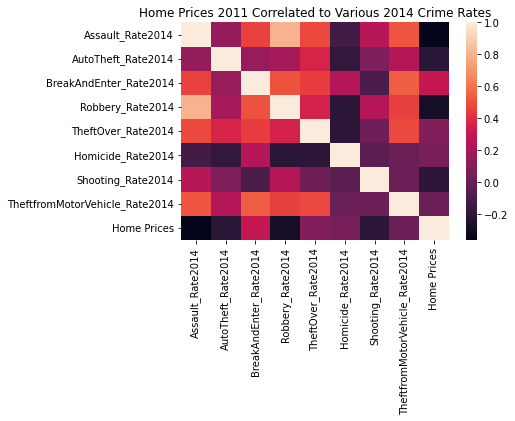

In [93]:
sns.heatmap(neighborhood_crime_2014.corr())
plt.title('Home Prices 2011 Correlated to Various 2014 Crime Rates')

Interestingly enough for the most part crime rates are either not associated with housing prices or have a negative correlation with housing prices, however break and enters have a positive correlation with the home prices of a neighborhood